In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
from imutils.object_detection import non_max_suppression
import imutils #pip install imutils         #helps to operate on edge contours in image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import cv2

In [6]:
def load_dataset():
    path = "/home/komlan/Datasets/Character_hand/Hnd/Img"
    #path = "/home/komlan/Datasets/myData"
    dir_chars = os.listdir(path)
    dir_chars.sort()
    labels = [chr(i) if i>=10 else i for i in list(range(10))+list(range(65,91))+list(range(97,123))]

    data_images = []
    for label, dir_label in enumerate(dir_chars):
        imgs_name_list = os.listdir(path+"/"+dir_label)
        for img_name in imgs_name_list:
            current_image = cv2.imread(path+"/"+dir_label+"/"+img_name)
            current_image = cv2.resize(current_image, (32,32))
            current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
            data_images.append([current_image, label])
    return np.array(data_images)

In [7]:
"""data_images = load_dataset()
data_images = pd.DataFrame(data_images, columns=["images", "labels"])
data_images.shape
"""

'data_images = load_dataset()\ndata_images = pd.DataFrame(data_images, columns=["images", "labels"])\ndata_images.shape\n'

In [112]:
X = data_images["images"].values
y = data_images["labels"].values
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, test_size=0.2, random_state=42)

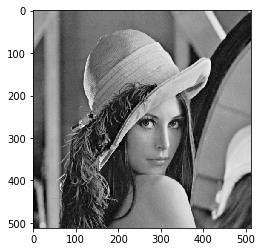

(512, 512)

In [107]:
img = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img, cmap='gray')
plt.show()
img.shape

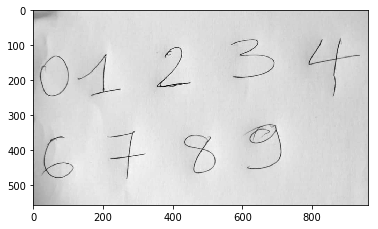

(558, 960)

In [8]:
img = cv2.imread('image_test.jpeg', cv2.IMREAD_GRAYSCALE)/255
plt.imshow(img, cmap='gray')
plt.show()
img.shape

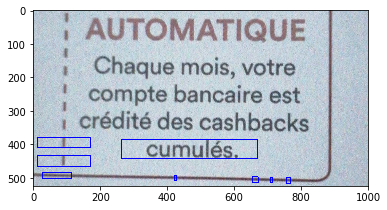

In [34]:
img = cv2.imread("test2.jpeg")

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold the grayscale image
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# use morphology erode to blur horizontally
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (151, 3))
morph = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

# use morphology open to remove thin lines from dotted lines
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 17))
morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

# find contours
cntrs = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

# find the topmost box
ythresh = 1000000
for c in cntrs:
    box = cv2.boundingRect(c)
    x,y,w,h = box
    if y < ythresh:
        topbox = box
        ythresh = y
plt.imshow()
# Draw contours excluding the topmost box
result = img.copy()
for c in cntrs:
    box = cv2.boundingRect(c)
    if box != topbox:
        x,y,w,h = box
        cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
        
plt.imshow(result)

In [31]:
class TextDetection:

    allImageLetters = []        
    labels = []   
    allWordInInputImage = []

    def __init__(self, size):
        self.size = size
        self.imageInput = "test2.jpeg"#  "receipt.png"
        self.pathDigits = "/home/komlan/datas/handwrite/hsf_0/digit/"
        self.pathLowLetter = "/home/komlan/datas/handwrite/hsf_0/lower"
        self.pathUppLetter = "/home/komlan/datas/handwrite/hsf_0/upper"
        self.eastFile = "/home/komlan/Programming/Python/modeles/CNN/frozen_east_text_detection.pb"
        self.sizeWidth = 640 #Must be a multiple of 32
        self.sizeHeight = 640
        self.padding = 0.05
        self.rateFind = 0.5

    def preprocessInputImage(self):
        image = cv2.imread(self.imageInput)
        orig = image.copy()
        imageShow  = orig.copy()
        (height, width) = image.shape[:2]
        #Get the rate to modify bound after
        rateHeight = height / float(self.sizeHeight)
        rateWidth = width / float(self.sizeWidth)
        image = cv2.resize(image, (self.sizeWidth, self.sizeHeight))
        
        #Prediction of text ereas
        layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
        net = cv2.dnn.readNet(self.eastFile)
        blob = cv2.dnn.blobFromImage(image, 1.0, (self.sizeWidth, self.sizeHeight), (123.68, 116.78, 103.94), swapRB=True, crop=False) #contruct blob from the image
        net.setInput(blob)
        (scores, geometry) = net.forward(layerNames)
        (rectangles, confidences) = self.decodePrediction(scores, geometry)
        boxes = non_max_suppression(np.array(rectangles), probs=confidences)
        
        rects = []
        for (startX, startY, endX, endY) in boxes:
            startX = int(startX * rateWidth)
            startY = int(startY * rateHeight)
            endX = int(endX * rateWidth)
            endY = int(endY * rateHeight)

            dX = int((endX - startX) * self.padding)
            dY = int((endY - startY) * self.padding)

            startX = max(0, startX - dX)
            startY = max(0, startY - dY)
            endX = min(width, endX + (dX * 2))
            endY = min(height, endY + (dY * 2))

            rects.append([startX, endX, startY, endY])
        
        rectsSort = self.sortRectangle(rects)
        #print(rectsSort)
        for rect in rectsSort:
            roi = orig[rect[2]:rect[3], rect[0]:rect[1]]
            self.allWordInInputImage.append([roi, [rect[0], rect[1], rect[2], rect[3]]])

            cv2.rectangle(imageShow, (rect[0], rect[2]), (rect[1], rect[3]), (0, 255, 0), 2)
            plt.imshow(roi)
            plt.show()
            
        plt.imshow(imageShow)

    def sortRectangle(self, rects):
        lenRec = len(rects)
        #Sort Y values
        for i in range(1,lenRec):
            k = i-1 
            while k >= 0 and rects[k][2] > rects[k+1][2]:
                t = rects[k+1]
                rects[k+1] = rects[k]
                rects[k] = t 
                k -= 1
        #Get the range of the same Y
        i = 0
        while i < lenRec:
            init = i
            end = i
            x = 1
            if i+x < lenRec and rects[i][2] == rects[i+x][2]:
                x += 1
                while i+x < lenRec and rects[i][2] == rects[i+x][2]:
                    x += 1
                end += x-1
                i += x
            else:
                i += 1
            #If there is no repetition for Y value continue
            if end - init == 0:
                continue
            
            #sort X values
            for j in range(init + 1, end+1):
                k = j-1 
                while k >= init and rects[k][0] > rects[k+1][0]:
                    t = rects[k+1]
                    rects[k+1] = rects[k]
                    rects[k] = t 
                    k -= 1
        return rects
        
    def decodePrediction(self, scores, geometry):
        (numbRows, numbCols) = scores.shape[2:4]
        rectangles = []
        confidences = []
        for j in range(numbRows):
            #get datas of the boxs in those lines
            scoreData = scores[0,0,j]
            xData0 = geometry[0,0,j]
            xData1 = geometry[0,1,j]
            xData2 = geometry[0,2,j]
            xData3 = geometry[0,3,j]
            angleData = geometry[0,4,j]
            for i in range(numbCols):
                if scoreData[i] < self.rateFind:
                    continue
                (offsetX, offsetY) = (i*4.0, j*4.0)

                angle = angleData[i]
                cos = np.cos(angle)
                sin = np.sin(angle)

                h = xData0[i] + xData2[i]
                w = xData1[i] + xData3[i]

                endX = int(offsetX + (cos * xData1[i]) + (sin * xData2[i]))
                endY = int(offsetY - (sin * xData1[i]) + (cos * xData2[i]))

                startX = int(endX - w)
                startY = int(endY - h)

                rectangles.append((startX, startY, endX, endY))
                
                confidences.append(scoreData[i])
            
        return (rectangles, confidences)

    def getLettersImage(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert to gray
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)     #remove all noise
        limitEdge = cv2.Canny(blurred, 30, 150)         #limit the contours
        findEdge = cv2.findContours(limitEdge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #get all contours
        findEdge = imutils.grab_contours(findEdge)
        findEdge = sort_contours(findEdge, method="left-to-right")[0]

        getChartRectangle = []
        for c in findEdge:
            (x, y, w, h) = cv2.boundingRect(c)
            if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
                crop = gray[y:y+h, x:x+w]   #crop the erea of the character
                thresh = cv2.threshold(crop, 0, 225, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
                tH, tW = thresh.shape
                if tW > tH:
                    thresh = imutils.resize(thresh, width=32)
                else:
                    thresh = imutils.resize(thresh, height=32)
                #cv2.imshow("image", thresh)
                #cv2.waitKey(0)
                #cv2.destroyAllWindows()
                #cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.imshow("image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

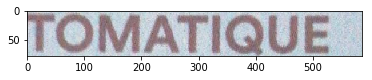

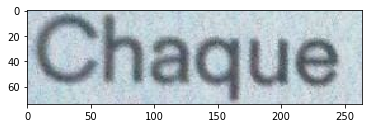

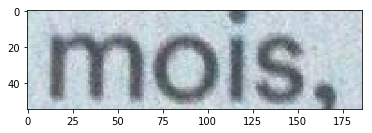

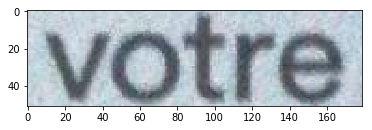

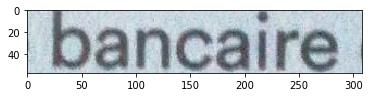

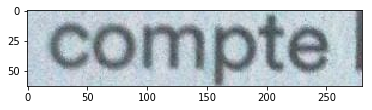

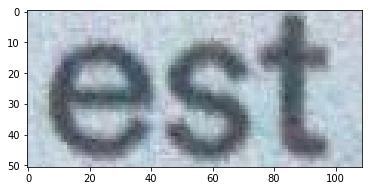

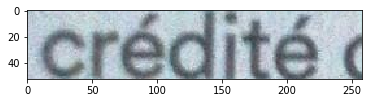

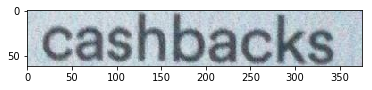

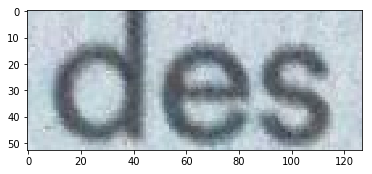

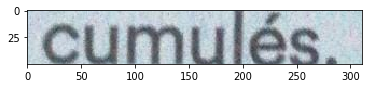

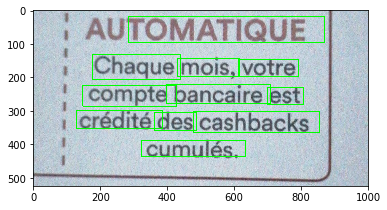

In [32]:
detect = TextDetection(32)
detect.preprocessInputImage()

In [19]:
class Convolution:
    def __init__(self, nb_filters, filter_size):
        self.nb_filters = nb_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn(nb_filters, filter_size, filter_size) / (filter_size * filter_size)
        
    def get_image_patchs(self, image):
        height, width = image.shape
        self.image = image
        for i in range(height - self.filter_size + 1):
            for j in range(width - self.filter_size + 1):
                image_patch = image[i : (i + self.filter_size), j: (j + self.filter_size)]
                yield image_patch, i, j
                
    def forward_propagation(self, image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.nb_filters))
        for image_patch, i, j in self.get_image_patchs(image):
            conv_out[i,j] = np.sum(image_patch * self.conv_filter, axis=(1,2))
        return conv_out
    
    def backward_propagation(self, dL_dout, learning_rate):
        dL_dF_params = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.get_image_patchs(self.image):
            for k in range(self.nb_filters):
                dL_dF_params[k] += image_patch * dL_dout[i, j, k]
        #update params
        self.conv_filter -= learning_rate * dL_dF_params
        return dL_dF_params

class MaxPool:
    def  __init__(self, filter_size):
        self.filter_size = filter_size
    
    def get_image_patchs(self, image):
        new_height = image.shape[0] // self.filter_size
        new_width = image.shape[1] // self.filter_size
        self.image = image
        for i in range(new_height):
            for j in range(new_width):
                image_patch = image[i * self.filter_size : i * self.filter_size + self.filter_size, j * self.filter_size : (j * self.filter_size + self.filter_size)]
                yield image_patch, i, j
                
    def forward_propagation(self, image):
        height, width, nb_filters = image.shape
        max_pool_out = np.zeros((height // self.filter_size, width // self.filter_size, nb_filters))
        for image_patch, i, j in self.get_image_patchs(image):
            max_pool_out[i,j] = np.amax(image_patch, axis=(0,1))
        return max_pool_out
    
    def backward_propagation(self, dL_dout):
        dL_dmax_pool = np.zeros(self.image.shape)
        for image_patch, i, j in self.get_image_patchs(self.image):
            height, width, nb_filters = image_patch.shape
            max_val = np.amax(image_patch, axis=(0,1))
            for i1 in range(height):
                for j1 in range(width):
                    for k1 in range(nb_filters):
                        if image_patch[i1, j1, k1] == max_val[k1]:
                            dL_dmax_pool[i * self.filter_size + i1, j * self.filter_size + j1, k1] = dL_dout[i,j,k1]
        return dL_dmax_pool

class SoftMax:
    def __init__(self, input_node, softmax_node):
        self.weight = np.random.randn(input_node, softmax_node) / input_node
        self.bias = np.zeros(softmax_node)
    
    def forward_propagation(self, image):
        self.orig_shape = image.shape
        
        image_flatten = image.flatten()
        self.image_flatten = image_flatten
        output_val = np.dot(image_flatten, self.weight) + self.bias
        self.out = output_val
        exp_out = np.exp(output_val)
        return  exp_out / np.sum(exp_out, axis=0)
    
    def backward_propagation(self, dL_dout, learning_rate):
        for i, gradient in enumerate(dL_dout):
            if gradient == 0:
                continue
            transform_equa = np.exp(self.out)
            s_total = np.sum(transform_equa)
            #Gradients with respect to out (z)
            dy_dz = -transform_equa[i] * transform_equa / (s_total ** 2) 
            dy_dz[i] = transform_equa[i] * (s_total - transform_equa[i]) / (s_total ** 2)
            #Gradients od totals against weights /bias/input
            dz_dw = self.image_flatten
            dz_db = 1
            dz_d_inp = self.weight
            #Gradients of loss against totals
            dL_dz = gradient * dy_dz
            #Gradients of loss against weight/biases/input
            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]
            dL_db = dL_dz * dz_db
            dL_d_inp = dz_d_inp @ dL_dz
        #Update weights and biases
        self.weight -= learning_rate * dL_dw
        self.bias -= learning_rate * dL_db
        return dL_d_inp.reshape(self.orig_shape)
    
class CNN:
    def __init__(self, image_size, nb_class, nb_channel, conv_filter_size, pool_filter_size):
        self.nb_class = nb_class
        self.conv = Convolution(nb_channel, conv_filter_size)
        self.maxpool = MaxPool(pool_filter_size)
        self.softmax = SoftMax((((image_size - conv_filter_size +1) // pool_filter_size)**2)  * nb_channel, nb_class)
        
    def CNN_forward_propa(self, image, label):
        out = self.conv.forward_propagation(image/255)
        out = self.maxpool.forward_propagation(out)
        out = self.softmax.forward_propagation(out)
        #Calculate cross-entropy loss accuracy
        cross_entropy_loss = - np.log(out[label])
        accuracy_eval = 1 if np.argmax(out) == label else 0
        return out, cross_entropy_loss, accuracy_eval

    def CNN_backward_propa(self, image, label, learning_rate=0.005):
        out, loss, acc = self.CNN_forward_propa(image, label)
        #Calculate initial gradient
        gradient = np.zeros(self.nb_class)
        gradient[label] = -1 / out[label]
        #Backward
        grad = self.softmax.backward_propagation(gradient, learning_rate)
        grad = self.maxpool.backward_propagation(grad)
        grad = self.conv.backward_propagation(grad, learning_rate)
        return loss, acc 
    
    def training(self, epoch):
        for epoch in range(epoch):
            print("Epoch ", epoch+1, "---->")
            loss = 0
            num_correct = 0
            for i, (img, label) in enumerate(zip(X_train, y_train)):
                if i % 100 == 0:
                    print(i+1, " steps out of 100 steps: Average Loss ",loss/100," and Accuracy: ", num_correct,"%")
                    loss = 0
                    num_correct = 0
                l, acc = self.CNN_backward_propa(img, label)
                loss += l
                num_correct += acc
                
    def score(self, X_test, y_test):
        loss = 0
        num_correct = 0
        for i, (img, label) in enumerate(zip(X_test, y_test)):
            l, acc = self.CNN_backward_propa(img, label)
            loss += l
            num_correct += acc
        nb_sample = len(y_test)
        return loss / nb_sample, num_correct / nb_sample
            
    def predict(self, images):
        result = []
        for X in images:
            out = self.conv.forward_propagation(X/255)
            out = self.maxpool.forward_propagation(out)
            out = self.softmax.forward_propagation(out)
            result.append(np.argmax(out))
        return result
        


In [20]:
cnn = CNN(image_size=32, nb_class=62, nb_channel=8, conv_filter_size=3, pool_filter_size=2)
cnn.training(epoch=4)

Epoch  1 ---->


NameError: name 'X_train' is not defined

In [47]:
loss, accuracy = cnn.score(X_test, y_test)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

Accuracy:  0.9933333333333333
Loss:  0.06474375326452618


In [44]:
from runpy import run_path
#modules = run_path("/home/komlan/Programming/Python/modeles/CNN/modele.py")

import pickle
pickle_out = open("/home/komlan/Programming/Python/modeles/CNN/model_trained.p", "wb")
if __name__ == '__main__':
    pickle.dump(cnn, pickle_out)
    pickle_out.close()
    print("ghj")

ghj


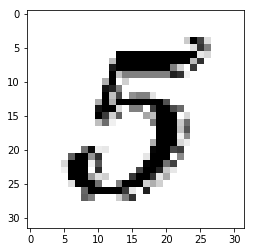

In [119]:
current_image = cv2.imread("/home/komlan/Datasets/myData/5/img006-00011.png")
current_image = cv2.resize(current_image, (32,32))
current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
plt.imshow(current_image, cmap='gray')
plt.show()

In [120]:
cnn.predict([current_image])

[28]

In [77]:
def score(X_test, y_test):
    loss = 0
    num_correct = 0
    for i, (img, label) in enumerate(zip(X_test, y_test)):
        l, acc = cnn.CNN_backward_propa(img, label)
        loss += l
        num_correct += acc
    nb_sample = len(y_test)
    return loss / nb_sample, num_correct / nb_sample

def predict(images):
    result = []
    for X in images:
        out = cnn.conv.forward_propagation(X/255)
        out = cnn.maxpool.forward_propagation(out)
        out = cnn.softmax.forward_propagation(out)
        result.append(np.argmax(out))
    return result

In [86]:
loss, accuracy = score(X_test, y_test)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

Accuracy:  0.9933333333333333
Loss:  0.015010518253520887


In [94]:
predict([X_test[32]])

[0]

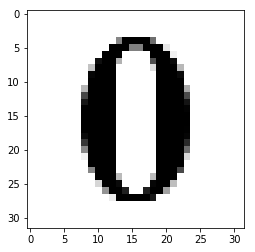

array([0, 0, 1, ..., 0, 1, 1], dtype=object)

In [103]:
#conv = Convolution(18, 7)
#out = conv.forward_propagation(img)
plt.imshow(X_test[210], cmap = 'gray')
plt.show()
out.shape
y_train

In [121]:
labels = [chr(i) if i>=10 else i for i in list(range(10))+list(range(65,91))+list(range(97,123))]
list(enumerate(labels))

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 4),
 (5, 5),
 (6, 6),
 (7, 7),
 (8, 8),
 (9, 9),
 (10, 'A'),
 (11, 'B'),
 (12, 'C'),
 (13, 'D'),
 (14, 'E'),
 (15, 'F'),
 (16, 'G'),
 (17, 'H'),
 (18, 'I'),
 (19, 'J'),
 (20, 'K'),
 (21, 'L'),
 (22, 'M'),
 (23, 'N'),
 (24, 'O'),
 (25, 'P'),
 (26, 'Q'),
 (27, 'R'),
 (28, 'S'),
 (29, 'T'),
 (30, 'U'),
 (31, 'V'),
 (32, 'W'),
 (33, 'X'),
 (34, 'Y'),
 (35, 'Z'),
 (36, 'a'),
 (37, 'b'),
 (38, 'c'),
 (39, 'd'),
 (40, 'e'),
 (41, 'f'),
 (42, 'g'),
 (43, 'h'),
 (44, 'i'),
 (45, 'j'),
 (46, 'k'),
 (47, 'l'),
 (48, 'm'),
 (49, 'n'),
 (50, 'o'),
 (51, 'p'),
 (52, 'q'),
 (53, 'r'),
 (54, 's'),
 (55, 't'),
 (56, 'u'),
 (57, 'v'),
 (58, 'w'),
 (59, 'x'),
 (60, 'y'),
 (61, 'z')]

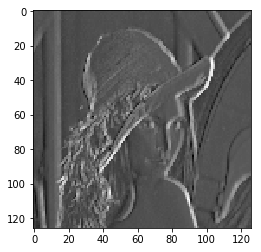

(126, 126, 18)

In [28]:
max_pool = MaxPool(4)
out2 = max_pool.forward_propagation(out)
plt.imshow(out2[:,:,17], cmap = 'gray')
plt.show()
out2.shape

In [29]:
soft_max = SoftMax(126*126*18, 10)
out3 = soft_max.forward_propagation(out2)
out3

array([0.09997825, 0.09998629, 0.10001011, 0.10001248, 0.10001062,
       0.09999444, 0.09997839, 0.09999997, 0.10002588, 0.10000356])

In [30]:
np.argmax(out3)

8

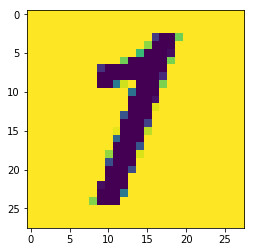

In [162]:
plt.imshow(data_images["images"][1290])

In [163]:
import cv2
import matplotlib.pyplot as plt

current_image = cv2.imread("/home/komlan/Datasets/myData/3/img004-00009.png")
current_image = cv2.resize(current_image, (32,32))
current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
plt.imshow(current_image, cmap='gray')
plt.show()

In [166]:

num_

Epoch  1 ---->
1  steps out of 100 steps: Average Loss  0.0  and Accuracy:  0
101  steps out of 100 steps: Average Loss  0.5094668476143864  and Accuracy:  79
201  steps out of 100 steps: Average Loss  0.18785706297661445  and Accuracy:  93
301  steps out of 100 steps: Average Loss  0.19546324177537652  and Accuracy:  92
401  steps out of 100 steps: Average Loss  0.1210962050470542  and Accuracy:  96
501  steps out of 100 steps: Average Loss  0.13775055543985926  and Accuracy:  95
601  steps out of 100 steps: Average Loss  0.07817314595546683  and Accuracy:  96
701  steps out of 100 steps: Average Loss  0.15688057667339542  and Accuracy:  93
801  steps out of 100 steps: Average Loss  0.306523417870255  and Accuracy:  94
901  steps out of 100 steps: Average Loss  0.04696999171856413  and Accuracy:  98
1001  steps out of 100 steps: Average Loss  0.14933565097641632  and Accuracy:  96
1101  steps out of 100 steps: Average Loss  0.02573977948253703  and Accuracy:  98
Epoch  2 ---->
1  step

In [62]:
import tensorflow as tf
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [106]:
np.array(X_train[0]).shape

(32, 32)

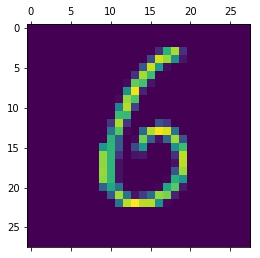

In [66]:
plt.matshow(X_train[18])

In [ ]:
#Database : #https://www.nist.gov/srd/nist-special-database-19
# https://www.kaggle.com/kartikeya47/characters-predictor-using-cnn-approach/data
#raw_data = pd.read_csv("/home/komlan/Datasets/handwritting/hand/A_Z-handwritting.csv")
# https://www.kaggle.com/kartikeya47/characters-predictor-using-cnn-approach/data

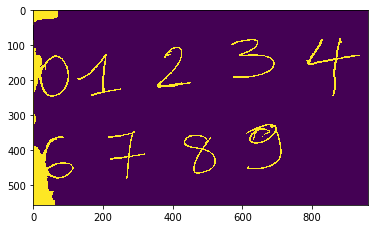

In [32]:
def load_dataset():
    #path = "/home/komlan/Datasets/Character_hand/Hnd/Img"
    path = "/home/komlan/Datasets/myData"
    dir_chars = os.listdir(path)
    dir_chars.sort()
    #chars_labels = list(enumerate(dir_chars))
    dir_chars
    labels = [chr(i) if i>=10 else i for i in list(range(10))+list(range(65,91))+list(range(97,123))]

    data_images = []
    for label, dir_label in enumerate(dir_chars):
        imgs_name_list = os.listdir(path+"/"+dir_label)
        for img_name in imgs_name_list:
            current_image = cv2.imread(path+"/"+dir_label+"/"+img_name)
            current_image = cv2.resize(current_image, (32,32))
            current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
            current_image = cv2.equalizeHist(current_image)
            current_image = current_image/255
            data_images.append([current_image, label])
    return np.array(data_images)


image = cv2.imread("image_test.jpeg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  #convert to gray
image = cv2.GaussianBlur(image, (5, 5), 0)     #remove all noise
image = cv2.threshold(image, 0, 225, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
#image = np.invert(np.array(image))
#image = cv2.resize(image, (28,28))

plt.imshow(image)

In [51]:
image = np.invert(np.array([image])) #invert white on Black to Black on White
prediction = model.predict(image)
print(np.ragmax(prediction))

AttributeError: 'tuple' object has no attribute 'shape'